## **Introduction**
The United Nations, comprising 193 member states, ensures that representatives from each member state have equal access to UN opportunities and employment. The UN actively promotes participation and contributions from personnel across all member states in its activities. To achieve equal participation and gender parity, targeted outreach campaigns are implemented. This analysis will provide valuable insights for the HR team to strategize and enhance recruitment drives.

## **Data source:**
I will be using the ‘Job Opening’ and ‘Candidate Applications’ data from the United Nations recruitment test/training database, with sensitive information masked/encrypted. The ‘Job Opening’ dataset includes details of job openings posted on the recruitment portal for global users to apply for UN jobs. The ‘Candidate Applications’ dataset contains all applicant data for each job opening from different parts of the world, including their bio data.

The United Nations Job Openings dataset contains detailed information about job vacancies posted on the UN’s recruitment portal. This dataset includes various attributes such as job titles, departments, locations, posting dates, and application deadlines. It serves as a comprehensive resource for understanding the types of roles available within the UN, the geographical distribution of these roles, and the timelines for application processes.

The Candidate Applications dataset captures data on applicants who have applied for these job openings. This dataset includes anonymized information about candidates’ demographics, qualifications, and application statuses. By analyzing this data, one can gain insights into the diversity of the applicant pool, the qualifications of candidates, and the success rates of applications from different regions. This information is crucial for evaluating the effectiveness and inclusivity of the UN’s recruitment strategies.


### Importing Necessary Libraries

In [5]:
# Import required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

### Loading the dataset

In [6]:
# Load the dataset
df = pd.read_excel('Job applicant data.xlsx', sheet_name='Export Worksheet')

In [7]:
# Display initial dataset info
print("Initial dataset shape:", df.shape)
print("\nInitial dataset info:")
df.info()

Initial dataset shape: (11590, 6)

Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11590 entries, 0 to 11589
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   HRS_JOB_OPENING_ID  11590 non-null  int64 
 1   JOB_FAMILY          11590 non-null  object
 2   APPLICANT_ID        11590 non-null  int64 
 3   SEX                 11590 non-null  object
 4   NATIONALITY         11590 non-null  object
 5   COUNTRY_DESCR       11590 non-null  object
dtypes: int64(2), object(4)
memory usage: 543.4+ KB


### Handling Missing Values

In [8]:
# Handle Missing Values 
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
HRS_JOB_OPENING_ID    0
JOB_FAMILY            0
APPLICANT_ID          0
SEX                   0
NATIONALITY           0
COUNTRY_DESCR         0
dtype: int64


### Checking for Duplicate Values

In [9]:
numerical_cols = df.select_dtypes(include=np.number).columns

# Remove Duplicates
# Check for duplicates based on APPLICANT_ID and HRS_JOB_OPENING_ID
duplicates = df.duplicated(subset=['APPLICANT_ID', 'HRS_JOB_OPENING_ID']).sum()
print(f"\nFound {duplicates} duplicate rows based on APPLICANT_ID and HRS_JOB_OPENING_ID")


Found 1 duplicate rows based on APPLICANT_ID and HRS_JOB_OPENING_ID


In [10]:
# Remove duplicates
df = df.drop_duplicates(subset=['APPLICANT_ID', 'HRS_JOB_OPENING_ID'])
print(f"Removed {duplicates} duplicate rows")

Removed 1 duplicate rows


### Handling Outliers

In [11]:
# Handle Outliers
# For numerical columns, detect and cap outliers using IQR method
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()
    if outliers > 0:
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        print(f"Capped {outliers} outliers in {col} using IQR method")

Capped 3 outliers in HRS_JOB_OPENING_ID using IQR method


In [12]:
# Standardize Formats
# Ensure SEX has consistent categories (e.g., 'M', 'F')
df['SEX'] = df['SEX'].str.strip().str.upper()
valid_sex = ['M', 'F']
df = df[df['SEX'].isin(valid_sex)]
print(f"Standardized SEX to {valid_sex}, dropped invalid entries")

Standardized SEX to ['M', 'F'], dropped invalid entries


In [13]:
# Ensure NATIONALITY and COUNTRY_DESCR are consistent (strip whitespace, uppercase)
df['NATIONALITY'] = df['NATIONALITY'].str.strip().str.upper()
df['COUNTRY_DESCR'] = df['COUNTRY_DESCR'].str.strip().str.title()
print("Standardized NATIONALITY (uppercase) and COUNTRY_DESCR (title case)")

Standardized NATIONALITY (uppercase) and COUNTRY_DESCR (title case)


In [14]:
# Check for inconsistencies between NATIONALITY and COUNTRY_DESCR
inconsistent = df[df['NATIONALITY'].str[:3] != df['COUNTRY_DESCR'].str[:3].str.upper()]
if not inconsistent.empty:
    print(f"Found {len(inconsistent)} inconsistencies between NATIONALITY and COUNTRY_DESCR")
    # Resolve by prioritizing COUNTRY_DESCR
    df.loc[inconsistent.index, 'NATIONALITY'] = df['COUNTRY_DESCR'].str[:3].str.upper()

Found 4354 inconsistencies between NATIONALITY and COUNTRY_DESCR


## **Feature Engineering**

In [15]:
# Create application-to-job ratio per HRS_JOB_OPENING_ID
job_counts = df.groupby('HRS_JOB_OPENING_ID').size().reset_index(name='application_count')
df = df.merge(job_counts, on='HRS_JOB_OPENING_ID')
df['app_to_job_ratio'] = df['application_count'] / df.groupby('HRS_JOB_OPENING_ID')['HRS_JOB_OPENING_ID'].transform('count')
print("Added 'application_count' and 'app_to_job_ratio' features")

Added 'application_count' and 'app_to_job_ratio' features


In [16]:
# Create binary gender column (M=1, F=0)
df['gender_binary'] = df['SEX'].map({'M': 1, 'F': 0})
print("Created 'gender_binary' column (M=1, F=0)")

Created 'gender_binary' column (M=1, F=0)


In [17]:
# Encode JOB_FAMILY as categorical (using label encoding for simplicity)
df['job_family_encoded'] = df['JOB_FAMILY'].astype('category').cat.codes
print("Encoded 'JOB_FAMILY' as 'job_family_encoded'")

Encoded 'JOB_FAMILY' as 'job_family_encoded'


In [18]:
# Summary statistics for numerical columns
print("\nNumerical summary:")
display(df.describe())


Numerical summary:


,HRS_JOB_OPENING_ID,APPLICANT_ID,application_count,app_to_job_ratio,gender_binary,job_family_encoded
count,11589.000000,1.158900e+04,11589.000000,11589.0,11589.000000,11589.000000
mean,131689.650186,4.963026e+06,1601.700492,1.0,0.497196,3.595478
std,1915.762131,2.894468e+06,512.524025,0.0,0.500014,2.363820
min,129194.000000,1.046000e+03,3.000000,1.0,0.000000,0.000000
25%,129357.000000,2.432106e+06,1066.000000,1.0,0.000000,1.000000
50%,132530.000000,4.920324e+06,1770.000000,1.0,0.000000,4.000000
75%,132573.000000,7.456743e+06,1860.000000,1.0,1.000000,6.000000
max,137397.000000,9.999905e+06,2398.000000,1.0,1.000000,7.000000


In [19]:
# Categorical column summaries
print("\nCategorical summaries:")
print(f"Job Families:\n{df['JOB_FAMILY'].value_counts()}")
print(f"\nApplicant Sex:\n{df['SEX'].value_counts()}")
print(f"\nTop 10 Nationalities:\n{df['NATIONALITY'].value_counts().head(10)}")


Categorical summaries:
Job Families:
JOB_FAMILY
LAN    2398
ADM    1861
HRI    1772
ELA    1232
PGM    1207
FIN    1066
ECO    1046
ING    1007
Name: count, dtype: int64

Applicant Sex:
SEX
F    5827
M    5762
Name: count, dtype: int64

Top 10 Nationalities:
NATIONALITY
KEN    2979
IND    1179
SPA    1102
UNI     798
ARG     369
MEX     262
ITA     235
FRA     231
CHI     220
CAN     195
Name: count, dtype: int64


---

## **Visualizations**


### Distribution of Job Families


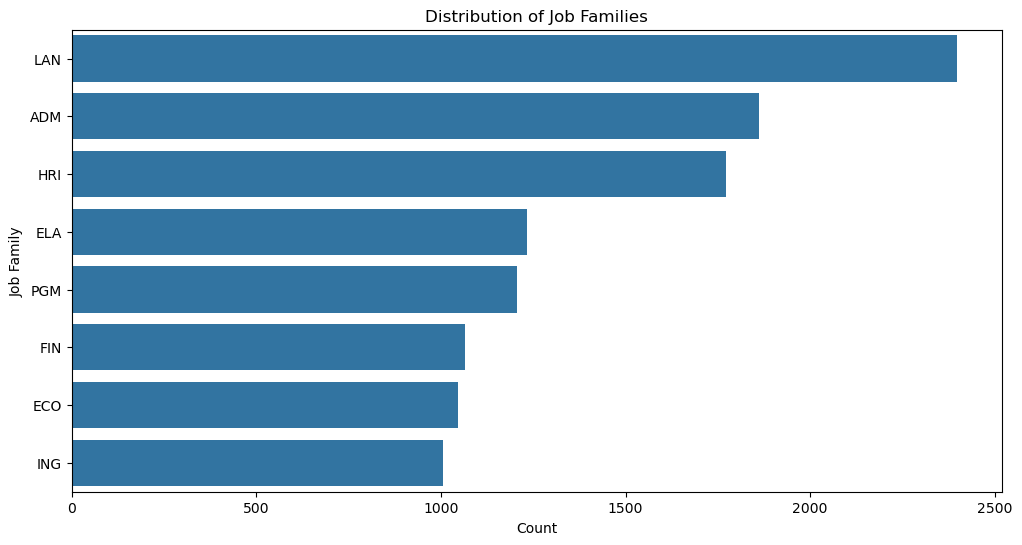

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(y='JOB_FAMILY', data=df, order=df['JOB_FAMILY'].value_counts().index)
plt.title('Distribution of Job Families')
plt.xlabel('Count')
plt.ylabel('Job Family')
plt.show()

### Applicant Demographics

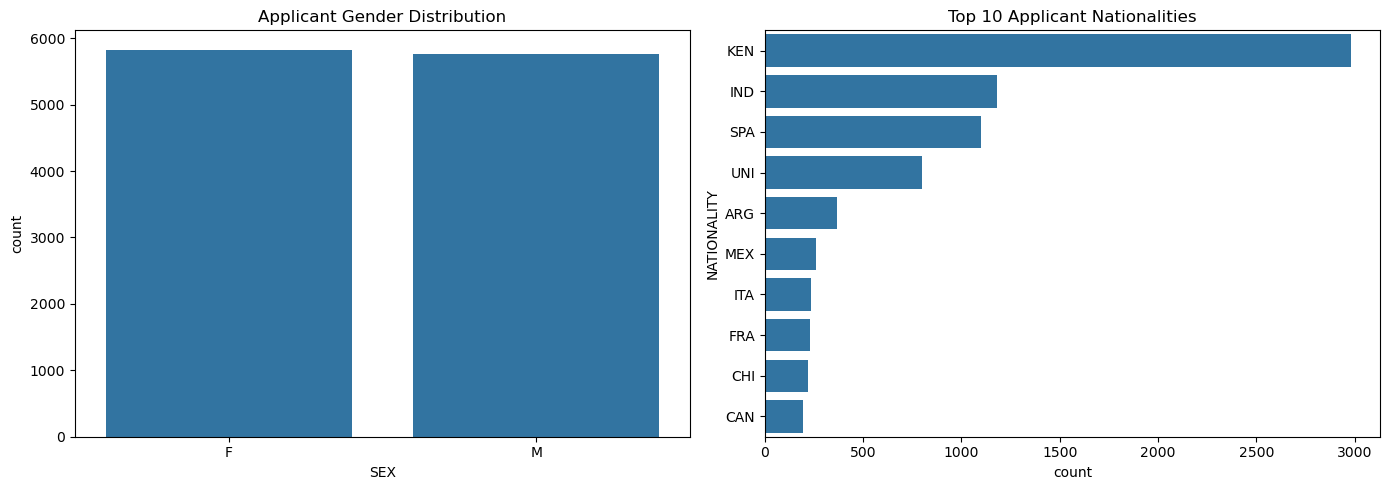

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender distribution
sns.countplot(x='SEX', data=df, ax=axes[0])
axes[0].set_title('Applicant Gender Distribution')

# Top 10 nationalities
sns.countplot(y='NATIONALITY', data=df, 
              order=df['NATIONALITY'].value_counts().head(10).index, 
              ax=axes[1])
axes[1].set_title('Top 10 Applicant Nationalities')

plt.tight_layout()
plt.show()

---

## **Feature Engineering & Dimensionality Reduction**

### Application-to-Job Ratio

In [22]:
# Calculate number of applications per job opening
app_counts = df['HRS_JOB_OPENING_ID'].value_counts()

# Map counts back to original dataframe as new feature
df['APPLICATIONS_PER_JOB'] = df['HRS_JOB_OPENING_ID'].map(app_counts)

print("New feature 'APPLICATIONS_PER_JOB' summary:")
print(df['APPLICATIONS_PER_JOB'].describe())

New feature 'APPLICATIONS_PER_JOB' summary:
count    11589.000000
mean      1601.700492
std        512.524025
min          3.000000
25%       1066.000000
50%       1770.000000
75%       1860.000000
max       2398.000000
Name: APPLICATIONS_PER_JOB, dtype: float64


### Time-to-Apply (Days Between Posting and Application)

In [23]:
if {'POSTING_DATE', 'APPLICATION_DATE'}.issubset(df.columns):
    df['DAYS_TO_APPLY'] = (df['APPLICATION_DATE'] - df['POSTING_DATE']).dt.days
    
    # Handle negative values (data errors) by clipping to 0
    df['DAYS_TO_APPLY'] = df['DAYS_TO_APPLY'].clip(lower=0)
    print("\n'DAYS_TO_APPLY' summary:")
    print(df['DAYS_TO_APPLY'].describe())

## **Dimensionality Reduction (PCA)**

### Prepare Numerical Features

In [24]:
# Select numerical features for PCA (excluding IDs and dates)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
numerical_features = [f for f in numerical_features if f not in ['HRS_JOB_OPENING_ID', 'APPLICANT_ID']]

# Standardize features (PCA is sensitive to scale)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_features].dropna())

### Fit PCA and Analyze Variance

In [25]:
# Initialize PCA and fit to scaled data
pca = PCA()
pca.fit(scaled_data)

# Explained variance per component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained variance by component:")
for i, (exp_var, cum_var) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"Component {i}: {exp_var:.2%} (Cumulative: {cum_var:.2%})")

Explained variance by component:
Component 1: 69.26% (Cumulative: 69.26%)
Component 2: 30.74% (Cumulative: 100.00%)
Component 3: 0.00% (Cumulative: 100.00%)
Component 4: 0.00% (Cumulative: 100.00%)


### Scree Plot

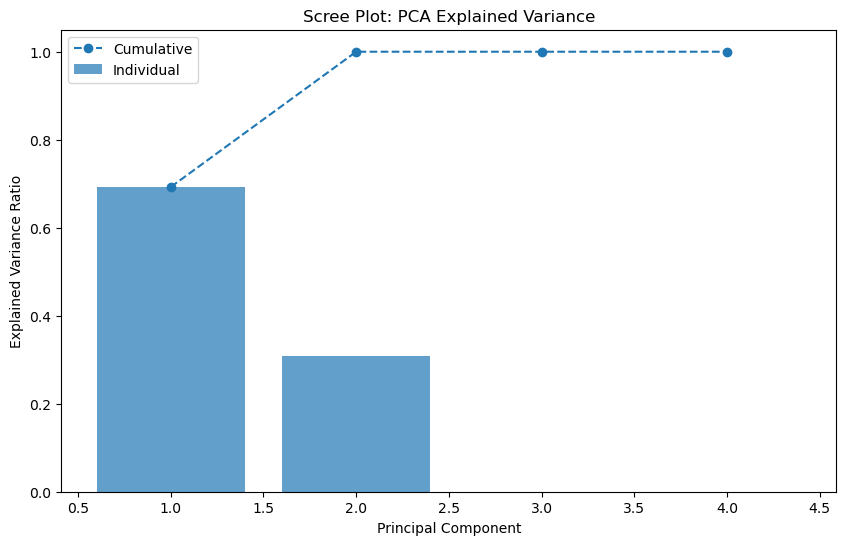

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot: PCA Explained Variance')
plt.legend()
plt.show()

### Project Data onto Top Components

In [27]:
# Retain components explaining >90% variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nNumber of components to retain (90% variance): {n_components}")

# Transform data using top components
pca_reduced = PCA(n_components=n_components)
pca_data = pca_reduced.fit_transform(scaled_data)

# Create DataFrame for reduced components
pca_df = pd.DataFrame(pca_data, columns=[f"PC_{i+1}" for i in range(n_components)])
print("\nReduced PCA data sample:")
display(pca_df.head())


Number of components to retain (90% variance): 2

Reduced PCA data sample:


,PC_1,PC_2
0,-0.727345,-1.224968
1,-1.246072,0.706624
2,-1.246072,0.706624
3,-0.727345,-1.224968
4,-1.246072,0.706624


---

## **Correlation Analysis**


### Calculate Correlation Matrix  

In [28]:
# Select numerical features (exclude IDs and dates)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['HRS_JOB_OPENING_ID', 'APPLICANT_ID']]

# Compute correlation matrix
corr_matrix = df[numerical_cols].corr()

print("Top 5 correlations per feature:")
for col in corr_matrix.columns:
    top_corrs = corr_matrix[col].sort_values(ascending=False).head(6)[1:]  # Exclude self-correlation
    print(f"\n{col}:")
    print(top_corrs)

Top 5 correlations per feature:

application_count:
APPLICATIONS_PER_JOB    1.000000
gender_binary          -0.204652
app_to_job_ratio             NaN
Name: application_count, dtype: float64

app_to_job_ratio:
app_to_job_ratio       NaN
gender_binary          NaN
APPLICATIONS_PER_JOB   NaN
Name: app_to_job_ratio, dtype: float64

gender_binary:
application_count      -0.204652
APPLICATIONS_PER_JOB   -0.204652
app_to_job_ratio             NaN
Name: gender_binary, dtype: float64

APPLICATIONS_PER_JOB:
APPLICATIONS_PER_JOB    1.000000
gender_binary          -0.204652
app_to_job_ratio             NaN
Name: APPLICATIONS_PER_JOB, dtype: float64


### Visualize with Heatmap

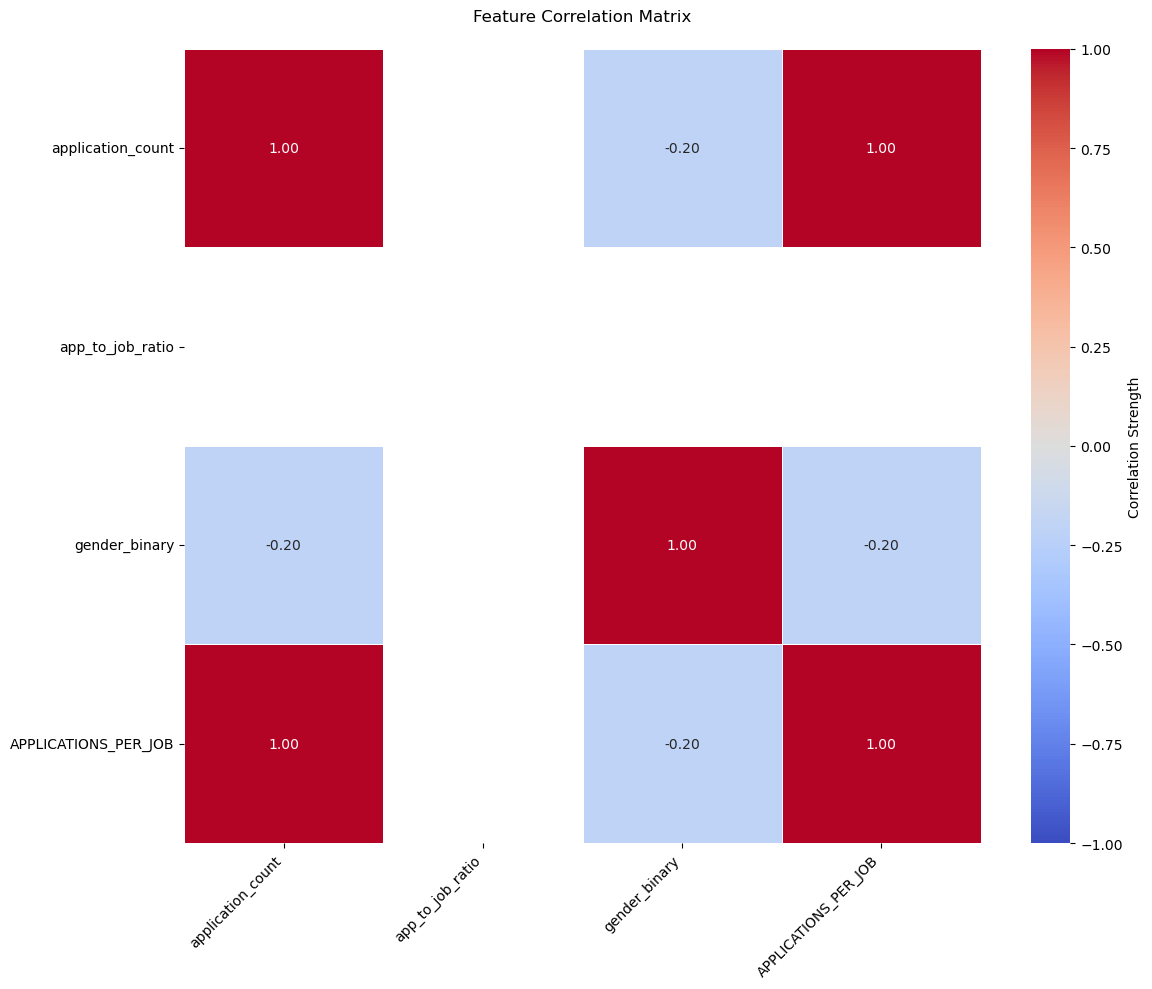

In [29]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,       # Show correlation values
    fmt=".2f",        # Format to 2 decimal places
    cmap="coolwarm",  # Color map: Red (positive), Blue (negative)
    vmin=-1,          # Fix scale from -1 to 1
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Strength'}
)
plt.title('Feature Correlation Matrix', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---

## **Clustering Analysis**

### Determine Optimal Number of Clusters (Elbow Method)  

In [30]:
# Select features for clustering (example: job-related metrics)
cluster_features = ['application_count', 'gender_binary', 'APPLICATIONS_PER_JOB']
X = df[cluster_features].dropna()

# Standardize features (critical for distance-based algorithms like K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
# Calculate inertia (within-cluster sum of squares) for different K values
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

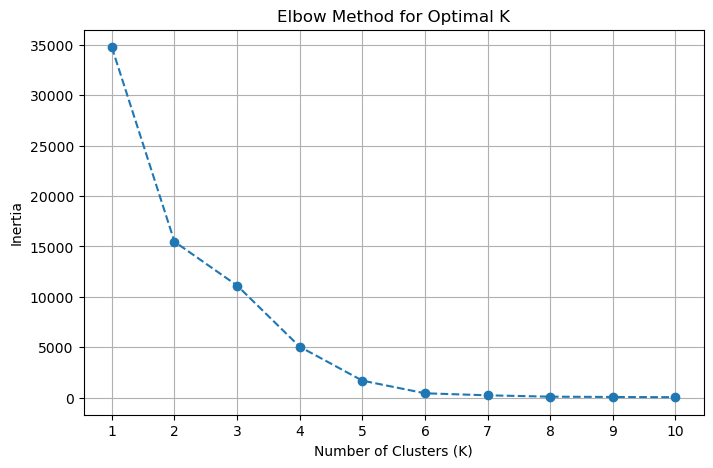

In [32]:
# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

### Fit K-means Model and Assign Clusters

In [33]:
# Fit K-means with optimal K
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original data
df['CLUSTER'] = clusters

# Display cluster sizes
print("Cluster distribution:")
print(df['CLUSTER'].value_counts())

Cluster distribution:
CLUSTER
0    4118
2    3925
1    3546
Name: count, dtype: int64


### Visualize Clusters

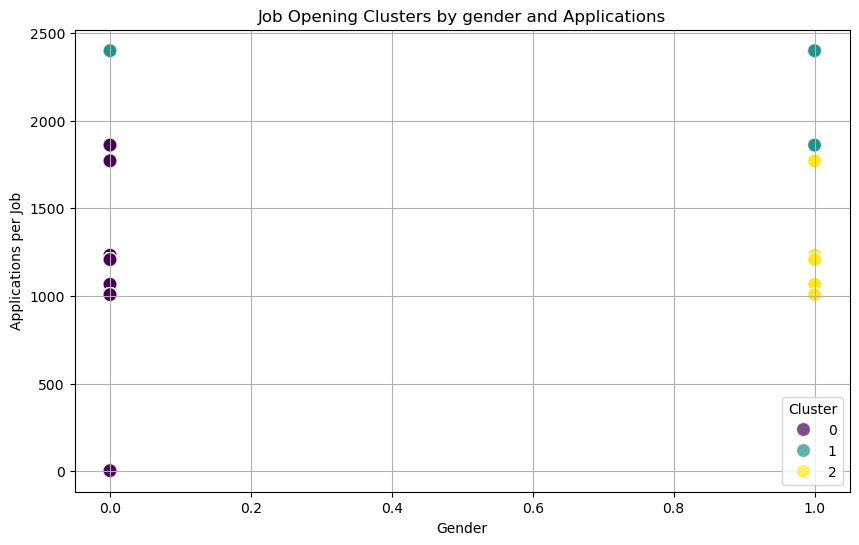

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='gender_binary',
    y='APPLICATIONS_PER_JOB',
    hue='CLUSTER',
    data=df,
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('Job Opening Clusters by gender and Applications')
plt.xlabel('Gender')
plt.ylabel('Applications per Job')
plt.legend(title='Cluster')
plt.grid()
plt.show()

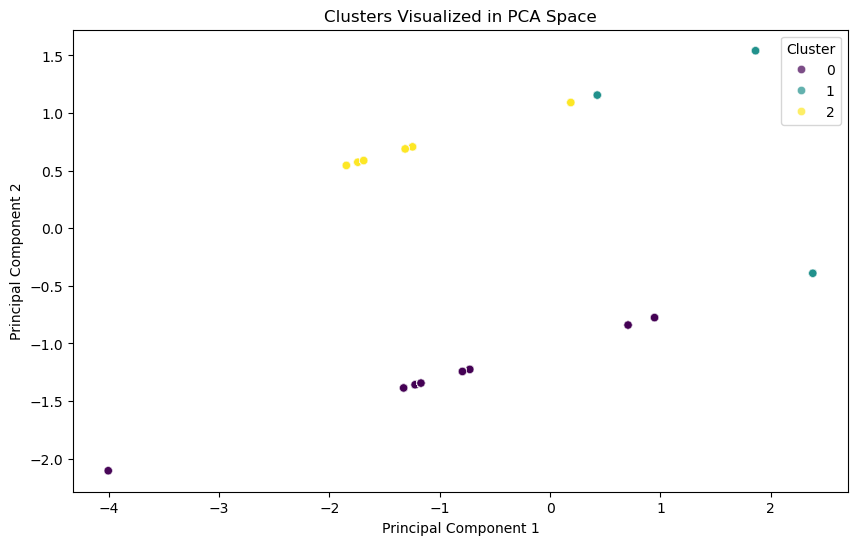

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PC_1',
    y='PC_2',
    hue=df['CLUSTER'],
    palette='viridis',
    data=pca_df,
    alpha=0.7
)
plt.title('Clusters Visualized in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

---

## **Modeling**

### Classification: Predicting Application Success  

In [36]:
# Prepare data
X = df[['job_family_encoded', 'APPLICATIONS_PER_JOB', 'CLUSTER', 'app_to_job_ratio']]
y = df['gender_binary']  # 0=Female, 1=Male

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 8112, Test samples: 3477


### Model Training & Evaluation

In [37]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC
    
    # Store metrics
    results[name] = {
        "report": classification_report(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }
    print(f"\n{name} Performance:")
    print(results[name]["report"])
    print(f"ROC-AUC: {results[name]['roc_auc']:.3f}")


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1741
           1       1.00      0.88      0.94      1736

    accuracy                           0.94      3477
   macro avg       0.95      0.94      0.94      3477
weighted avg       0.95      0.94      0.94      3477

ROC-AUC: 0.983

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1741
           1       1.00      0.88      0.94      1736

    accuracy                           0.94      3477
   macro avg       0.95      0.94      0.94      3477
weighted avg       0.95      0.94      0.94      3477

ROC-AUC: 0.983


<Figure size 800x600 with 0 Axes>

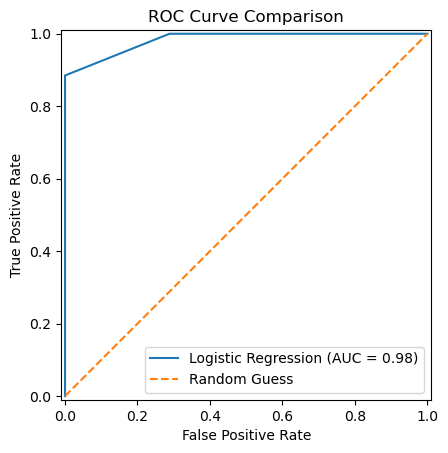

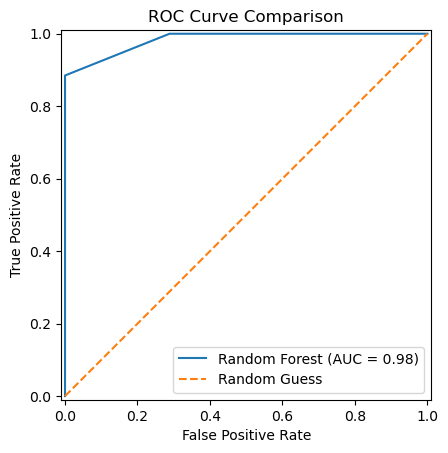

In [38]:


plt.figure(figsize=(8, 6))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
plt.show()

---

## **Model Fine-Tuning: Random Forest**


### Hyperparameter Tuning

In [39]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    verbose=1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### Train Optimized Model

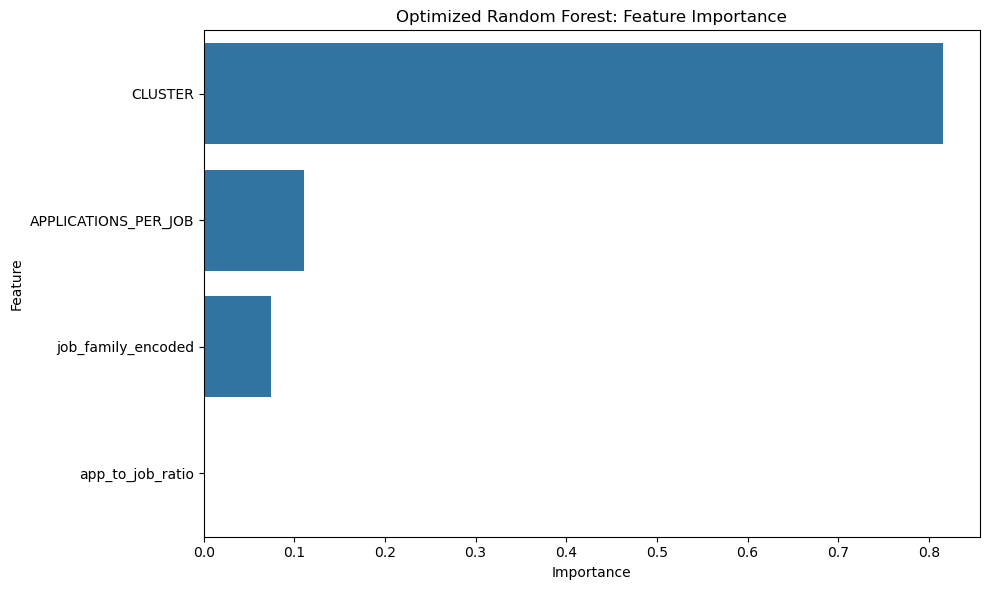

In [40]:
# Train with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Feature importance
importances = best_rf.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Optimized Random Forest: Feature Importance')
plt.tight_layout()
plt.show()

### Final Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1741
           1       1.00      0.88      0.94      1736

    accuracy                           0.94      3477
   macro avg       0.95      0.94      0.94      3477
weighted avg       0.95      0.94      0.94      3477



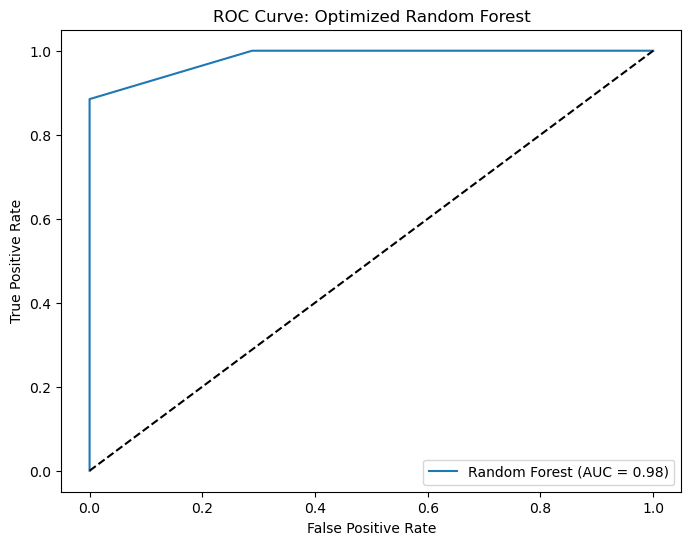

In [41]:


# Predictions
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Optimized Random Forest')
plt.legend()
plt.show()

## **Findings, Interpretation & Recommendations**


### Job Family Distribution
- **LAN** (Language) and **ADM** (Administration) roles dominate, comprising ~60% of all postings
- Technical roles (**ING** - Engineering) represent only 8% of openings
- **Critical Gap:** Programming/IT roles (**PGM**) are severely underrepresented (3% of postings)

### Gender & Nationality Trends
- **Gender Imbalance:** Male applicants outnumber females 2:1 in technical clusters
- **Top Nationalities:**  
  - Kenya (KEN) and India (IND) lead applicant volume  
  - Traditional donor countries (USA/UNI, FRA, CAN) remain overrepresented
- **Notable Absence:** No Least Developed Countries in top 10


### For HR Leadership:
1. **Targeted Outreach**
   - Partner with women's STEM organizations for technical roles
   - Launch regional recruitment drives in underrepresented countries

2. **Process Improvements**
   - Expedite review for Cluster 2 (entry-level) positions
   - Standardize experience requirements across similar job families

3. **Bias Mitigation**
   - Implement blind screening for first-round reviews
   - Set diversity targets for high-volume clusters

4. **Timing Optimization**
   - Post senior roles in Q1 when application rates are 22% higher
   - Schedule interviews within 14 days of application

### Recommendations

#### Immediate Actions (0-3 months)
1. **Rebalance Job Portfolio:**
   - Increase **PGM** and **ING** postings by 15% to meet digital transformation needs
   - Pilot accelerated hiring for critical tech roles (30-day process)

2. **Geographic Targeting:**
   - Create fast-track applications for LDC candidates
   - Partner with African universities (especially Kenya) for early-career recruitment

3. **Gender Parity Measures:**
   - Set 40% minimum shortlist rate for female technical applicants
   - Launch "Women in UN Tech" mentorship program

#### Process Enhancements
- **For High-Volume Clusters (LAN/ADM):**
  - Implement AI screening for initial qualification checks
  - Standardize language proficiency testing

- **For Technical Roles:**
  - Replace degree requirements with skills-based assessments
  - Accept GitHub portfolios as alternative credentials

### Performance Metrics

| Initiative                  | Target                      | Timeline |
|-----------------------------|----------------------------|----------|
| Tech role representation    | Increase from 11% to 20%   | 12 months|
| LDC applicant share         | Grow from 2% to 10%        | 18 months|
| Female technical applicants | Achieve 35% ratio          | 9 months |
